# Wiktoria Zajączkowska

# Temat 1

Przewidywanie ceny domów. Celem projektu jest zastosowanie modeli regresji do przewidzenia ceny domu o podanych cechach.

## Link do danych: 
​web.stanford.edu/class/stats191/data/ames2000_NAfix.csv 
Dokładny opis danych: ​http://web.stanford.edu/class/stats191/data/amesdoc.txt 
Zmienna celu (cena domu): SalePrice

## Wymogi:
<ul>
<li> Musi zostać wykorzystany model regresji liniowej.
<li> Muszą zostać wykorzystane ​przynajmniej dwie inne metody​regresji: regresja Ridge, regresja Lasso, drzewo regresyjne, las losowy regresyjny, XGBoost lub inne).
<li> Trzeba uwzględnić optymalizację modeli/pipelinów.
<li> Nie usuwamy żadnych obserwacji - braki danych uzupełniamy w jakiś sposób.
<li> Wszelkie nieoczywiste ​przekształcenia danych należy opatrzyć uzasadnieniem​dlaczego
dokonujemy tego przekształcenia (np. robimy wykres i uzasadniamy wzięcie logarytmu ze
zmiennej tym, że rozkład jest skośny).
<li> Musi pojawić się ocena graficzna predykcji modeli (np. wykresy wartości przewidywanych od
prawdziwych czy wykresy reziduów).
<li> Projekt musi być zakończony przejrzystym porównaniem przetestowanych rozwiązań
(modeli/pipelinów) ​w postaci tabeli,​gdzie jeden wiersz opisuje jedno rozwiązanie i jego wynik.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, scale, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils import class_weight
from xgboost.sklearn import XGBClassifier
from scipy.stats import norm
from scipy import stats
from sklearn.svm import SVC

from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Część I - oczyszczanie danych

#### Importuję dane ze źródła w formie tabeli. Ustawiam parametry tabeli, tak aby mieć podgląd wszystkich kolumn i wierszy (nie uruchamiam, aby nie obciazac notebooka w trakcie sprawdzania)

In [2]:
#pd.set_option('display.max_columns', 80)
#pd.set_option('display.max_rows', 2000)
data = pd.read_csv('http://web.stanford.edu/class/stats191/data/ames2000_NAfix.csv')
data

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,...,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,None,None,0,9,2006,New,Partial,342643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,80,RL,80,8000,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,GdWo,None,0,7,2009,WD,Normal,138000
1996,180,RM,35,3675,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,6,2008,WD,Normal,148000
1997,60,RL,76,10142,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,1,2010,WD,Normal,233000
1998,85,RL,None,7252,Pave,None,IR1,Lvl,AllPub,CulDSac,...,0,None,None,None,0,4,2009,WD,Normal,134900


#### Stosuję podział na y -> zmienną objaśnianą oraz x -> zmienne objaśniające i dzielę dane na część treningową i testową

In [3]:
y = data.SalePrice
X = data.drop(['SalePrice'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [4]:
X_train.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,...,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition
984,80,RL,None,10448,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,GdPrv,None,0,8,2009,COD,Abnorml
1922,20,RL,None,12285,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,8,2009,WD,Normal
1752,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
1798,20,RL,None,17600,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,12,2009,WD,Normal
1862,20,RL,75,7500,Pave,None,Reg,Lvl,AllPub,Corner,...,0,0,None,MnPrv,None,0,6,2010,WD,Normal


In [5]:
pd.set_option('display.max_columns', 79)
X_train.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition
984,80,RL,None,10448,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,Norm,Norm,1Fam,SLvl,6,6,1972,1972,Gable,CompShg,HdBoard,HdBoard,BrkFace,333,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,689,689,GasA,TA,Y,SBrkr,1378,741,0,2119,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1972,RFn,2,583,TA,TA,Y,0,104,0,0,0,0,None,GdPrv,None,0,8,2009,COD,Abnorml
1922,20,RL,None,12285,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Nonemes,Norm,Norm,1Fam,1Story,7,6,1960,1960,Gable,CompShg,Plywood,Plywood,BrkFace,128,TA,TA,CBlock,TA,TA,No,BLQ,544,Unf,0,785,1329,GasA,Gd,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,TA,5,Typ,2,Gd,Attchd,1960,Unf,2,441,TA,TA,Y,0,0,203,0,0,0,None,None,None,0,8,2009,WD,Normal
1752,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml
1798,20,RL,None,17600,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Nonemes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,30,TA,TA,CBlock,TA,TA,No,BLQ,1270,Unf,0,208,1478,GasA,Ex,Y,FuseA,1478,0,0,1478,1,0,2,0,3,1,TA,6,Typ,2,Gd,Attchd,1960,Unf,2,498,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,12,2009,WD,Normal
1862,20,RL,75,7500,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,5,1963,1963,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,CBlock,TA,TA,No,ALQ,824,Unf,0,216,1040,GasA,Fa,Y,SBrkr,1040,0,0,1040,1,0,1,1,3,1,TA,5,Typ,0,None,Attchd,1963,Fin,1,308,TA,TA,Y,0,0,220,0,0,0,None,MnPrv,None,0,6,2010,WD,Normal


#### Stosuję jednolity format dwóch miejsc po przecinku dla danych numerycznych, dla lepszego odczytu danych

In [6]:
pd.set_option('float_format', '{:.2f}'.format)
X_train.describe()

,MS.SubClass,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,TotRms.AbvGrd,Fireplaces,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Misc.Val,Mo.Sold,Yr.Sold
count,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00,1600.00
mean,56.34,10247.28,6.08,5.59,1971.42,1984.10,1159.08,337.50,3.48,1500.06,1.56,0.38,2.88,1.04,6.47,0.60,96.08,46.80,23.09,1.88,14.65,3.25,44.56,6.26,2007.78
std,41.79,7508.60,1.39,1.11,29.75,20.90,378.01,430.38,36.13,507.85,0.55,0.50,0.83,0.21,1.59,0.65,129.73,65.57,62.62,18.86,52.13,44.21,458.54,2.74,1.32
min,20.00,1300.00,1.00,1.00,1880.00,1950.00,453.00,0.00,0.00,480.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00
25%,20.00,7559.50,5.00,5.00,1954.00,1965.00,882.00,0.00,0.00,1123.75,1.00,0.00,2.00,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,2007.00
50%,50.00,9533.50,6.00,5.00,1972.00,1993.00,1086.00,0.00,0.00,1440.00,2.00,0.00,3.00,1.00,6.00,1.00,0.00,26.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00
75%,70.00,11622.75,7.00,6.00,2000.00,2004.00,1383.25,704.00,0.00,1743.00,2.00,1.00,3.00,1.00,7.00,1.00,171.00,74.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00
max,190.00,164660.00,10.00,9.00,2010.00,2010.00,4692.00,2065.00,515.00,5642.00,3.00,2.00,8.00,2.00,14.00,4.00,870.00,742.00,584.00,290.00,480.00,800.00,15500.00,12.00,2010.00


#### Zmienną objaśnianą y jest SalePrice. Sprawdzam jej skośność. Zmienna SalePrice ma dpozytywną skośność - bardzo mała liczba domów ma bardzo wysoką cenę sprzedaży, wykres jest wybrzuszony. Krzywa cena sprzedaży nie przyjmuje kształtu funkcji liniowej. Muszę więc przekształcić zmienną SalePrice tak, aby została spłaszczona.

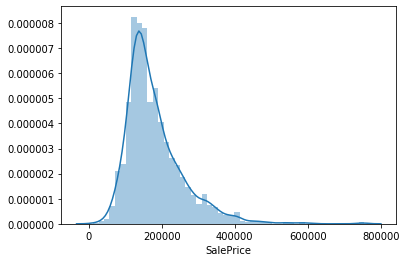

In [7]:
sns.distplot(y_train)
plt.show()

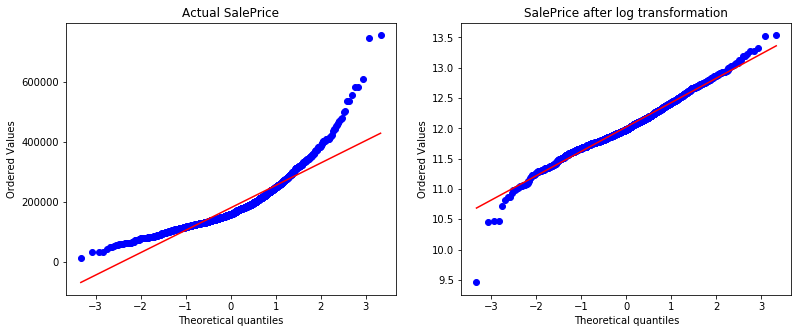

<Figure size 432x288 with 0 Axes>

In [8]:
figure = plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
stats.probplot(y_train, plot = plt)
plt.title('Actual SalePrice')
plt.subplot(1,2,2)

y_train = np.log(y_train)
stats.probplot(y_train, plot = plt)
plt.title('SalePrice after log transformation')
plt.show()
plt.savefig('SalePrice.jpg')

#### Buduję tabelę pozwalającą na analizę rodzaju zmiennych.
<ul>
<li> Column_types -> rozróżniam kolumny z danymi kategorycznymi i numerycznymi
<li> NaN_amount -> identyfikuję (ilość) wartości NaN w kolumnach
<li> Unique_values_amount -> identyfikuję ilość unikalnych wartości 
<li> Unique_values -> identyfikuję konkretne wartości występujące jako unikalne (pogrupowane)

In [9]:
df = X_train
pd.set_option('display.max_rows', 80)
column_types = [df[column].dtype for column in df.columns]
NaN_amount = [df[column].isna().sum(axis=0) for column in df.columns]
unique_values_amount = [np.unique(df[column].astype(str)).size for column in df.columns]
unique_values = [np.unique(df[column].astype(str)) for column in df.columns]
df_describe = pd.DataFrame({
    'Column_names': df.columns, 
    'Column_types': column_types, 
    'NaN_amount': NaN_amount,
    'Unique_value_amount': unique_values_amount, 
    'Unique_values': unique_values})
df_describe

,Column_names,Column_types,NaN_amount,Unique_value_amount,Unique_values
0,MS.SubClass,int64,0,15,"[120, 160, 180, 190, 20, 30, 40, 45, 50, 60, 7..."
1,MS.Zoning,object,0,7,"[A (agr), C (all), FV, I (all), RH, RL, RM]"
2,Lot.Frontage,object,0,117,"[100, 101, 102, 103, 104, 105, 106, 107, 108, ..."
3,Lot.Area,int64,0,1178,"[10000, 10004, 10005, 10007, 10010, 10011, 100..."
4,Street,object,0,2,"[Grvl, Pave]"
5,Alley,object,0,3,"[Grvl, None, Pave]"
6,Lot.Shape,object,0,4,"[IR1, IR2, IR3, Reg]"
7,Land.Contour,object,0,4,"[Bnk, HLS, Low, Lvl]"
8,Utilities,object,0,1,[AllPub]
9,Lot.Config,object,0,5,"[Corner, CulDSac, FR2, FR3, Inside]"


#### Identyfikuję kolumny z danymi wyłącznie numerycznymi

In [10]:
numeric_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(numeric_columns)

['MS.SubClass', 'Lot.Area', 'Overall.Qual', 'Overall.Cond', 'Year.Built', 'Year.Remod.Add', 'X1st.Flr.SF', 'X2nd.Flr.SF', 'Low.Qual.Fin.SF', 'Gr.Liv.Area', 'Full.Bath', 'Half.Bath', 'Bedroom.AbvGr', 'Kitchen.AbvGr', 'TotRms.AbvGrd', 'Fireplaces', 'Wood.Deck.SF', 'Open.Porch.SF', 'Enclosed.Porch', 'X3Ssn.Porch', 'Screen.Porch', 'Pool.Area', 'Misc.Val', 'Mo.Sold', 'Yr.Sold']


In [11]:
print(len(numeric_columns), 'numerical columns')

25 numerical columns


#### Identyfikuję kolumny z danymi wyłącznie kategorycznymi

In [12]:
categoric_columns = X_train.select_dtypes(include=[object]).columns.tolist()
print(categoric_columns)

['MS.Zoning', 'Lot.Frontage', 'Street', 'Alley', 'Lot.Shape', 'Land.Contour', 'Utilities', 'Lot.Config', 'Land.Slope', 'Neighborhood', 'Condition.1', 'Condition.2', 'Bldg.Type', 'House.Style', 'Roof.Style', 'Roof.Matl', 'Exterior.1st', 'Exterior.2nd', 'Mas.Vnr.Type', 'Mas.Vnr.Area', 'Exter.Qual', 'Exter.Cond', 'Foundation', 'Bsmt.Qual', 'Bsmt.Cond', 'Bsmt.Exposure', 'BsmtFin.Type.1', 'BsmtFin.SF.1', 'BsmtFin.Type.2', 'BsmtFin.SF.2', 'Bsmt.Unf.SF', 'Total.Bsmt.SF', 'Heating', 'Heating.QC', 'Central.Air', 'Electrical', 'Bsmt.Full.Bath', 'Bsmt.Half.Bath', 'Kitchen.Qual', 'Functional', 'Fireplace.Qu', 'Garage.Type', 'Garage.Yr.Blt', 'Garage.Finish', 'Garage.Cars', 'Garage.Area', 'Garage.Qual', 'Garage.Cond', 'Paved.Drive', 'Pool.QC', 'Fence', 'Misc.Feature', 'Sale.Type', 'Sale.Condition']


In [13]:
print(len(categoric_columns), 'categorical columns')

54 categorical columns


#### Sortuję tabelę wg typu danych w celu przejścia do transformacji danych kategorycznych na numeryczne

In [14]:
df_describe.sort_values(by=['Column_types'])

,Column_names,Column_types,NaN_amount,Unique_value_amount,Unique_values
0,MS.SubClass,int64,0,15,"[120, 160, 180, 190, 20, 30, 40, 45, 50, 60, 7..."
44,Low.Qual.Fin.SF,int64,0,18,"[0, 108, 144, 156, 259, 312, 360, 362, 390, 39..."
45,Gr.Liv.Area,int64,0,924,"[1000, 1001, 1003, 1004, 1005, 1006, 1008, 100..."
48,Full.Bath,int64,0,4,"[0, 1, 2, 3]"
49,Half.Bath,int64,0,3,"[0, 1, 2]"
50,Bedroom.AbvGr,int64,0,8,"[0, 1, 2, 3, 4, 5, 6, 8]"
51,Kitchen.AbvGr,int64,0,3,"[0, 1, 2]"
53,TotRms.AbvGrd,int64,0,11,"[10, 11, 12, 14, 3, 4, 5, 6, 7, 8, 9]"
55,Fireplaces,int64,0,5,"[0, 1, 2, 3, 4]"
43,X2nd.Flr.SF,int64,0,438,"[0, 1008, 1012, 1017, 1020, 1028, 1036, 1037, ..."


#### Bazując na powyższej tabeli przechodzę do eliminacji wartości NaN zamieniając je na 'None', bądź '0' w zależności od danych występujących w unikalnych wartościach

In [15]:
X_train["Mas.Vnr.Type"].fillna('None', inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [16]:
X_train['Lot.Frontage'].fillna(0, inplace=True)

In [17]:
X_train["Garage.Cond"].fillna('None', inplace=True)
X_train['Garage.Finish'].fillna('None', inplace=True)
X_train['Garage.Qual'].fillna('None', inplace=True)
X_train['Mas.Vnr.Type'].fillna('None', inplace=True)
X_train['BsmtFin.Type.2'].fillna('None', inplace=True)
X_train['BsmtFin.Type.1'].fillna('None', inplace=True)
X_train['Bsmt.Exposure'].fillna('None', inplace=True)
X_train['Bsmt.Cond'].fillna('None', inplace=True)
X_train['Bsmt.Qual'].fillna('None', inplace=True)

In [18]:
X_train['Electrical'].fillna(X_train['Electrical'].mode()[0], inplace=True)

In [19]:
X_train.isna().values.sum()

0

#### Przechodzę do transformacji danych kategorycznych na numeryczne. Dla ułatwienia sortuję tabelę po ilości unikalnych zmiennnych aby po kolei je transformować w odpowiedni sposób.

In [20]:
df_describe.sort_values(by=['Unique_value_amount'])

,Column_names,Column_types,NaN_amount,Unique_value_amount,Unique_values
8,Utilities,object,0,1,[AllPub]
40,Central.Air,object,0,2,"[N, Y]"
4,Street,object,0,2,"[Grvl, Pave]"
49,Half.Bath,int64,0,3,"[0, 1, 2]"
5,Alley,object,0,3,"[Grvl, None, Pave]"
64,Paved.Drive,object,0,3,"[N, P, Y]"
51,Kitchen.AbvGr,int64,0,3,"[0, 1, 2]"
10,Land.Slope,object,0,3,"[Gtl, Mod, Sev]"
27,Exter.Cond,object,0,4,"[Ex, Fa, Gd, TA]"
48,Full.Bath,int64,0,4,"[0, 1, 2, 3]"


#### W przypadku ilości unikalnych wartości mniejszej niż 10 stosuję podział numeryczny w porządku rankingowym określonym na podstawie opisu danych pod linkiem http://web.stanford.edu/class/stats191/data/amesdoc.txt

In [21]:
X_train['Utilities'] = X_train['Utilities'].apply(lambda x: x if 'AllPub' else 'Other')
X_train['Utilities'] = X_train['Utilities'].map({"Other":0, 
                                                 "AllPub":1})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
mp = {'N': 0, 'Y':1}
for feat in ['Central.Air']:
 X_train[feat] = X_train[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
mp = {'Grvl':2, 'Pave':1}
for feat in ['Street']:
 X_train[feat] = X_train[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
mp = {'None': 0, 'Grvl':2, 'Pave':1}
for feat in ['Alley']:
 X_train[feat] = X_train[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
mp = {'Gtl': 3, 'Mod':2, 'Sev':1}
for feat in ['Land.Slope']:
 X_train[feat] = X_train[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
mp = {'Y': 3, 'P':2, 'N':1}
for feat in ['Paved.Drive']:
 X_train[feat] = X_train[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
mp = {'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1}
for feat in ['Exter.Qual', 'Exter.Cond', 'Kitchen.Qual']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
mp = {'Reg': 4, 'IR1':3, 'IR2':2, 'IR3':1}
for feat in ['Lot.Shape']:
 X_train[feat] = X_train[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
mp = {'Lvl': 4, 'Bnk':3, 'HLS':2, 'Low':1}
for feat in ['Land.Contour']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
mp = {'SBrkr': 4, 'FuseA':3, 'FuseF':2, 'FuseP':1}
for feat in ['Electrical']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
mp = {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
for feat in ['Heating.QC']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
mp = {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0}
for feat in ['Bsmt.Qual', 'Bsmt.Cond', 'Garage.Qual', 'Garage.Cond', 'Fireplace.Qu']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
mp = {'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'None':0}
for feat in ['Pool.QC']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
mp = {'BrkCmn': 4, 'BrkFace':3, 'CBlock':2, 'Stone':1, 'None':0}
for feat in ['Mas.Vnr.Type']:
 X_train[feat] = X_train[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df["Mas.Vnr.Type"] = df["Mas.Vnr.Type"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
mp = {'1Fam': 5, '2fmCon':4, 'Duplex':3, 'Twnhs':2, 'TwnhsE':1}
for feat in ['Bldg.Type']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
mp = {'Fin': 3, 'RFn':2, 'Unf':1, 'None':0}
for feat in ['Garage.Finish']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
mp = {'Inside': 4, 'Corner':3, 'CulDSac':2, 'FR2':1, 'FR3':0}
for feat in ['Lot.Config']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
mp = {'GdPrv': 4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'None':0}
for feat in ['Fence']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
mp = {'Gar2': 4, 'Othr':3, 'Shed':2, 'TenC':1, 'None':0}
for feat in ['Misc.Feature']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
mp = {'Floor': 6, 'GasA':5, 'GasW':4, 'Grav':3, 'OthW':2, 'Wall':1}
for feat in ['Heating']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
mp = {'Gd': 4, 'Av':3, 'Mn':2, 'No':1, 'None':0}
for feat in ['Bsmt.Exposure']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
mp = {'Normal': 6, 'Abnorml':5, 'AdjLand':4, 'Alloca':3, 'Family':2, 'Partial':1}
for feat in ['Sale.Condition']:
 X_train[feat] = X_train[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
mp = {'A (agr)': 7, 'C (all)':6, 'FV':5, 'I (all)':4, 'RH':3, 'RL':2, 'RM':1}
for feat in ['MS.Zoning']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
mp = {'Artery': 7, 'Feedr':6, 'Norm':5, 'PosA':4, 'PosN':3, 'RRNn':2, 'RRAn':1}
for feat in ['Condition.2']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
mp = {'Artery': 9, 'Feedr':8, 'Norm':7, 'RRNn':6, 'RRAn':5, 'PosN':4, 'PosA':3, 'RRNe':2, 'RRAe':1}
for feat in ['Condition.1']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
mp = {'BrkTil': 6, 'CBlock':5, 'PConc':4, 'Slab':3, 'Stone':2, 'Wood':1}
for feat in ['Foundation']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
mp = {'Flat': 6, 'Gable':5, 'Gambrel':4, 'Hip':3, 'Mansard':2, 'Shed':1}
for feat in ['Roof.Style']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
mp = {'ClyTile': 7, 'CompShg':6, 'Membran':5, 'Metal':4, 'Tar&Grv':3, 'WdShake':2, 'WdShngl':1}
for feat in ['Roof.Matl']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
mp = {'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1}
for feat in ['Functional']:
 X_train[feat] = X_train[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
mp = {'GLQ': 6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'None':0}
for feat in ['BsmtFin.Type.1', 'BsmtFin.Type.2']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
mp = {'1Story': 8, '1.5Fin':7, '1.5Unf':6, '2Story':5, '2.5Fin':4, '2.5Unf':3, 'SFoyer':2, 'SLvl':1}
for feat in ['House.Style']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
mp = {'2Types': 6, 'Attchd':5, 'Basment':4, 'BuiltIn':3, 'CarPort':2, 'Detchd':1, 'None':0}
for feat in ['Garage.Type']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
mp = {'WD':10, 'CWD':9, 'VWD':8, 'New':7, 'COD':6, 'Con':5, 'ConLw':4, 'ConLI':3, 'ConLD':2, 'Oth':1}
for feat in ['Sale.Type']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### W tym miejscu mam problemy z pojawiającymi się ciągla NaN, więc porownalam pozyskane dane z poczatkowymi danymi - widzę, że w miejscu NaN widnieje wartość 'WD', wiec zamieniam NaN na liczbę przyporządkowaną tej kategorii powyżej

In [55]:
X_train['Sale.Type'].fillna(10, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


#### Wartość 'None', czyli brak danych zamieniam na '0'

In [56]:
mp = {'None': 0, '1':1, '2':2, '3':3, "0":0}
for feat in ['Bsmt.Full.Bath']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
mp = {'None': 0, '1':1, '2':2, '0':0}
for feat in ['Bsmt.Half.Bath']:
 X_train[feat] = X_train[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### W momencie, gdy w kategorii zmiennych pojawia się więcej niż 10 wartości, przechodze do bardziej zaawansowanej analizy oraz transformacji danych zgodnie z podziałem na klasy najczęściej występujących wartości. Swoją analizę opieram na wizualizacji danych w formie wykresu kolumnowego.

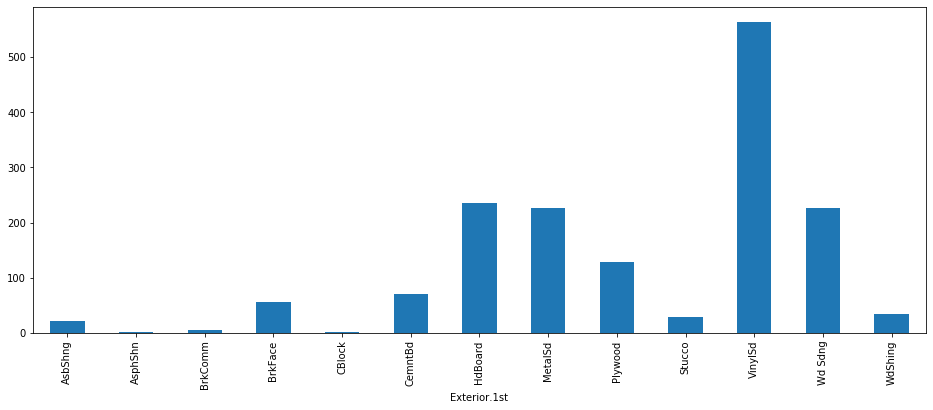

In [58]:
plt.subplots(figsize=(16,6))
a = X_train.groupby(['Exterior.1st'])['Exterior.1st'].count()
a.plot(kind='bar')
plt.show()

#### Dzięki wizualizacji danych widzę najczęściej występujące kategorie, przyjmuję więc granicę (w tym przypadku 250) i tworzę kategorię 'Other'

In [59]:
df_exterior = pd.DataFrame(X_train['Exterior.1st'].value_counts())
exterior_list = (df_exterior[(df_exterior['Exterior.1st'] > 250)].index)

In [60]:
X_train['Exterior.1st'] = X_train['Exterior.1st'].apply(lambda x: x if x in exterior_list else 'Other')
X_train['Exterior.1st'] = X_train['Exterior.1st'].map({"Other":1, 
                                                       "Wd Sdng":2,
                                                       'HdBoard':3, 
                                                       'MetalSd':4, 
                                                       'VinylSd':5})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Analogicznie w kolejnych przypadkach:

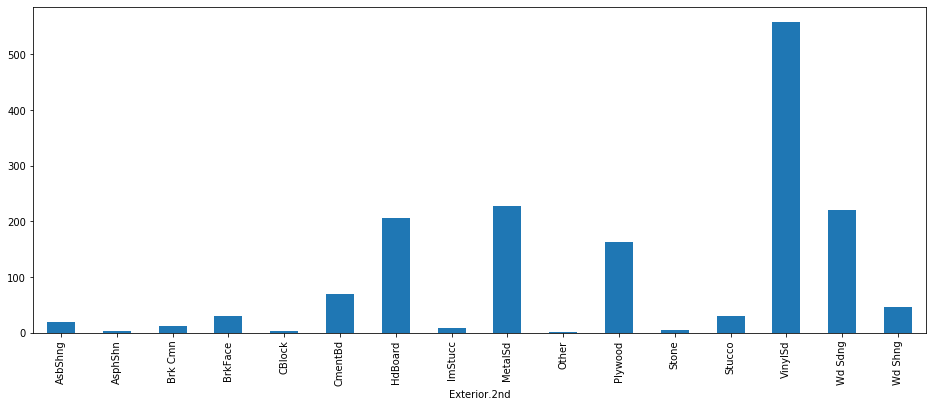

In [61]:
plt.subplots(figsize=(16,6))
a = X_train.groupby(['Exterior.2nd'])['Exterior.2nd'].count()
a.plot(kind='bar')
plt.show()

In [62]:
df_exterior2 = pd.DataFrame(X_train['Exterior.2nd'].value_counts())
exterior2_list = (df_exterior2[(df_exterior2['Exterior.2nd'] > 100)].index)

In [63]:
exterior2_list

Index(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'Plywood'], dtype='object')

In [64]:
X_train['Exterior.2nd'] = X_train['Exterior.2nd'].apply(lambda x: x if x in exterior2_list else 'Other')
X_train['Exterior.2nd'] = X_train['Exterior.2nd'].map({"Other":1, 
                                                       'Plywood':2,
                                                       "Wd Sdng":3,
                                                       'HdBoard':4, 
                                                       'MetalSd':5, 
                                                       'VinylSd':6})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


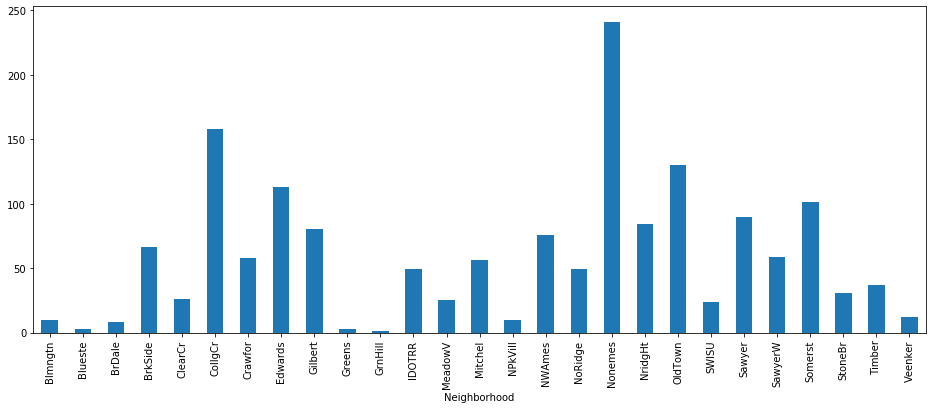

In [65]:
plt.subplots(figsize=(16,6))
a = X_train.groupby(['Neighborhood'])['Neighborhood'].count()
a.plot(kind='bar')
plt.show()

In [66]:
df_neighborhood = pd.DataFrame(X_train['Neighborhood'].value_counts())
neighborhood_list = (df_neighborhood[(df_neighborhood['Neighborhood'] > 50)].index)

In [67]:
neighborhood_list

Index(['Nonemes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'Sawyer',
       'NridgHt', 'Gilbert', 'NWAmes', 'BrkSide', 'SawyerW', 'Crawfor',
       'Mitchel'],
      dtype='object')

In [68]:
X_train['Neighborhood'] = X_train['Neighborhood'].apply(lambda x: x if x in neighborhood_list else 'Other')
X_train['Neighborhood'] = X_train['Neighborhood'].map({"Other":1, 
                                                       'IDOTRR':2,
                                                       'Crawfor':3,
                                                       'Mitchel':4,
                                                       'BrkSide':5, 
                                                       'SawyerW':6, 
                                                       'NWAmes':7,
                                                       'Sawyer':8,
                                                       'NridgHt':9,
                                                       'Gilbert':10,
                                                       'Somerst':11,
                                                       'Edwards':12,
                                                       'OldTown':13,
                                                       'CollgCr':14,
                                                       'Nonemes':15})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


#### W przypadku pojednynczych wartosci 'None' przyjmuje dla nich wartość numeryczną 0, ponieważ jest to dla mnie brak danych. Dodatkowo transformuję rodzaj danych na int

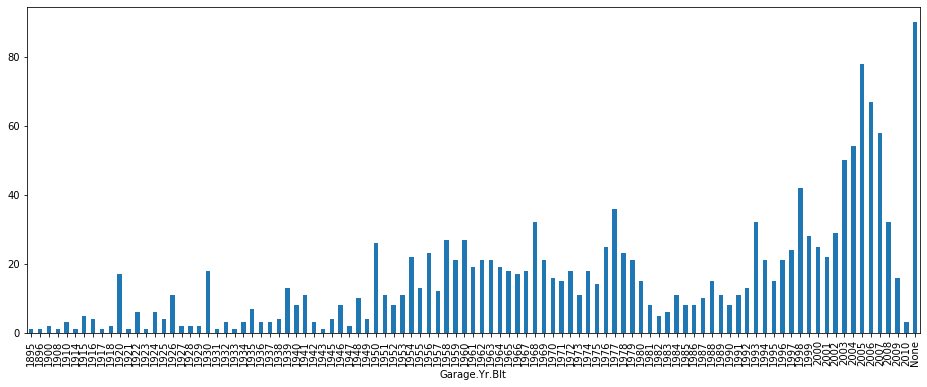

In [69]:
plt.subplots(figsize=(16,6))
a = X_train.groupby(['Garage.Yr.Blt'])['Garage.Yr.Blt'].count()
a.plot(kind='bar')
plt.show()

In [70]:
filter = X_train['Garage.Yr.Blt']=='None'
X_train['Garage.Yr.Blt'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [71]:
X_train["Garage.Yr.Blt"] = X_train["Garage.Yr.Blt"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
filter = X_train['Lot.Frontage']=='None'
X_train['Lot.Frontage'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
X_train["Lot.Frontage"] = X_train["Lot.Frontage"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [74]:
filter = X_train['BsmtFin.SF.2']=='None'
X_train['BsmtFin.SF.2'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
X_train["BsmtFin.SF.2"] = X_train["BsmtFin.SF.2"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
filter = X_train['Garage.Area']=='None'
X_train['Garage.Area'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
X_train["Garage.Area"] = X_train["Garage.Area"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
filter = X_train['BsmtFin.SF.1']=='None'
X_train['BsmtFin.SF.1'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
X_train["BsmtFin.SF.1"] = X_train["BsmtFin.SF.1"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
filter = X_train['Total.Bsmt.SF']=='None'
X_train['Total.Bsmt.SF'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [81]:
X_train["Total.Bsmt.SF"] = X_train["Total.Bsmt.SF"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
filter = X_train['Bsmt.Unf.SF']=='None'
X_train['Bsmt.Unf.SF'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
X_train["Bsmt.Unf.SF"] = X_train["Bsmt.Unf.SF"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
filter = X_train['Garage.Cars']=='None'
X_train['Garage.Cars'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
X_train["Garage.Cars"] = X_train["Garage.Cars"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
filter = X_train['Mas.Vnr.Area']=='None'
X_train['Mas.Vnr.Area'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [87]:
X_train['Mas.Vnr.Area'] = X_train['Mas.Vnr.Area'].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Po transformacji danych kategorycznych na numeryczne weryfikuję kompletność procesu w pełnej tabeli oraz używając funkcji info

In [88]:
#pd.set_option('display.max_columns', 79)
#pd.set_option('display.max_rows', 1600)

X_train

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition
984,80,2,0,10448,1,0,3,4,1,3,3,7,7,5,5,1,6,6,1972,1972,5,6,1,4,3,333,2,2,5,3,3,1,1,0,1,0,689,689,5,3,1,4,1378,741,0,2119,0,0,2,1,3,1,2,7,8,1,3,5,1972,2,2,583,3,3,3,0,104,0,0,0,0,0,4,0,0,8,2009,6.00,5
1922,20,2,0,12285,1,0,3,4,1,4,3,15,7,5,5,8,7,6,1960,1960,5,6,1,2,3,128,2,2,5,3,3,1,4,544,1,0,785,1329,5,4,1,4,1329,0,0,1329,0,0,1,1,3,1,2,5,8,2,4,5,1960,1,2,441,3,3,3,0,0,203,0,0,0,0,0,0,0,8,2009,10.00,6
1752,70,2,60,9550,1,0,3,4,1,3,3,3,7,5,5,5,7,5,1915,1970,5,6,1,1,0,0,2,2,6,3,4,1,5,216,1,0,540,756,5,4,1,4,961,756,0,1717,1,0,1,0,3,1,3,7,8,1,4,1,1998,1,3,642,3,3,3,0,35,272,0,0,0,0,0,0,0,2,2006,10.00,5
1798,20,2,0,17600,1,0,3,4,1,4,3,15,7,5,5,8,6,5,1960,1960,5,6,1,3,3,30,2,2,5,3,3,1,4,1270,1,0,208,1478,5,5,1,3,1478,0,0,1478,1,0,2,0,3,1,2,6,8,2,4,5,1960,1,2,498,3,3,3,0,40,0,0,0,0,0,0,0,0,12,2009,10.00,6
1862,20,2,75,7500,1,0,4,4,1,3,3,8,8,5,5,8,5,5,1963,1963,5,6,1,4,0,0,2,2,5,3,3,1,5,824,1,0,216,1040,5,2,1,4,1040,0,0,1040,1,0,1,1,3,1,2,5,8,0,0,5,1963,3,1,308,3,3,3,0,0,220,0,0,0,0,3,0,0,6,2010,10.00,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,20,5,85,10625,1,0,4,4,1,4,3,11,7,5,5,8,7,5,2006,2007,5,6,5,6,0,0,3,2,4,4,3,1,6,1430,1,0,222,1652,5,5,1,4,1662,0,0,1662,1,0,2,0,3,1,4,8,8,1,4,5,2006,2,3,711,3,3,3,168,120,0,0,0,0,0,0,0,0,3,2009,10.00,6
1249,20,2,65,8775,1,0,4,4,1,4,3,14,7,5,5,8,5,5,1994,1994,5,6,5,6,0,0,2,2,4,4,3,1,6,495,1,0,495,990,5,4,1,4,990,0,0,990,0,0,1,0,3,1,2,5,8,0,0,5,1996,1,1,299,3,3,3,0,64,0,0,0,0,0,0,0,0,4,2007,10.00,6
782,190,1,60,10800,1,2,4,4,1,4,3,13,7,5,4,7,6,6,1940,1950,5,6,1,3,0,0,2,2,5,3,3,1,4,590,1,0,294,884,5,3,1,4,884,552,0,1436,0,0,2,0,3,2,2,8,8,2,4,1,1940,1,2,828,3,3,3,0,0,126,0,0,0,0,0,0,0,5,2008,5.00,6
443,50,2,59,16466,1,0,3,4,1,4,3,12,7,5,5,7,5,7,1955,1955,5,6,1,5,0,0,2,3,4,3,3,1,1,0,1,0,816,816,5,3,1,4,872,521,0,1393,0,0,1,1,3,1,2,8,8,0,0,5,1955,1,1,300,3,3,3,121,0,0,0,265,0,0,0,0,0,4,2008,10.00,6


In [89]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 984 to 643
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS.SubClass      1600 non-null   int64  
 1   MS.Zoning        1600 non-null   int64  
 2   Lot.Frontage     1600 non-null   int64  
 3   Lot.Area         1600 non-null   int64  
 4   Street           1600 non-null   int64  
 5   Alley            1600 non-null   int64  
 6   Lot.Shape        1600 non-null   int64  
 7   Land.Contour     1600 non-null   int64  
 8   Utilities        1600 non-null   int64  
 9   Lot.Config       1600 non-null   int64  
 10  Land.Slope       1600 non-null   int64  
 11  Neighborhood     1600 non-null   int64  
 12  Condition.1      1600 non-null   int64  
 13  Condition.2      1600 non-null   int64  
 14  Bldg.Type        1600 non-null   int64  
 15  House.Style      1600 non-null   int64  
 16  Overall.Qual     1600 non-null   int64  
 17  Overall.Cond 

#### W celu identyfikacji danych odstających i ewentualnej optymalizacji obliczam średnią oraz odchylenie standardowe dla wszystkich kolumn (zmiennych)

In [90]:
X_train.mean(0)

MS.SubClass          56.34
MS.Zoning             2.05
Lot.Frontage         58.27
Lot.Area          10247.28
Street                1.00
Alley                 0.10
Lot.Shape             3.60
Land.Contour          3.84
Utilities             1.00
Lot.Config            3.58
Land.Slope            2.95
Neighborhood          8.85
Condition.1           6.92
Condition.2           5.00
Bldg.Type             4.53
House.Style           6.44
Overall.Qual          6.08
Overall.Cond          5.59
Year.Built         1971.42
Year.Remod.Add     1984.10
Roof.Style            4.61
Roof.Matl             5.94
Exterior.1st          2.41
Exterior.2nd          4.08
Mas.Vnr.Type          1.01
Mas.Vnr.Area        101.08
Exter.Qual            2.40
Exter.Cond            2.10
Foundation            4.62
Bsmt.Qual             3.48
Bsmt.Cond             2.93
Bsmt.Exposure         1.62
BsmtFin.Type.1        3.60
BsmtFin.SF.1        446.18
BsmtFin.Type.2        1.30
BsmtFin.SF.2         53.00
Bsmt.Unf.SF         550.94
T

In [91]:
X_train.std(0)

MS.SubClass         41.79
MS.Zoning            0.88
Lot.Frontage        33.92
Lot.Area          7508.60
Street               0.06
Alley                0.42
Lot.Shape            0.58
Land.Contour         0.56
Utilities            0.00
Lot.Config           0.80
Land.Slope           0.24
Neighborhood         5.01
Condition.1          0.99
Condition.2          0.17
Bldg.Type            1.17
House.Style          1.98
Overall.Qual         1.39
Overall.Cond         1.11
Year.Built          29.75
Year.Remod.Add      20.90
Roof.Style           0.82
Roof.Matl            0.47
Exterior.1st         1.91
Exterior.2nd         1.83
Mas.Vnr.Type         1.37
Mas.Vnr.Area       182.56
Exter.Qual           0.57
Exter.Cond           0.37
Foundation           0.73
Bsmt.Qual            0.89
Bsmt.Cond            0.57
Bsmt.Exposure        1.07
BsmtFin.Type.1       2.10
BsmtFin.SF.1       454.53
BsmtFin.Type.2       1.01
BsmtFin.SF.2       175.78
Bsmt.Unf.SF        437.42
Total.Bsmt.SF      432.49
Heating     

#### Identyfikuję kolumny, w których wystepuje największe odchylenie wartości od średniej, wizualizuję rozkład danych poprzez wykres pudełkowy i przechodzę do tzw. obsługi outlierów

In [92]:
outlier_columns = ['MS.SubClass', 'Lot.Frontage', 'Lot.Area', 'Mas.Vnr.Area', 'BsmtFin.SF.1', 'BsmtFin.SF.2', 'Bsmt.Unf.SF', 'Total.Bsmt.SF',
                   'X1st.Flr.SF', 'X2nd.Flr.SF', 'Low.Qual.Fin.SF', 'Gr.Liv.Area', 'Garage.Area', 'Wood.Deck.SF',
                   'Open.Porch.SF', 'Enclosed.Porch', 'X3Ssn.Porch', 'Screen.Porch', 'Pool.Area', 'Misc.Val']

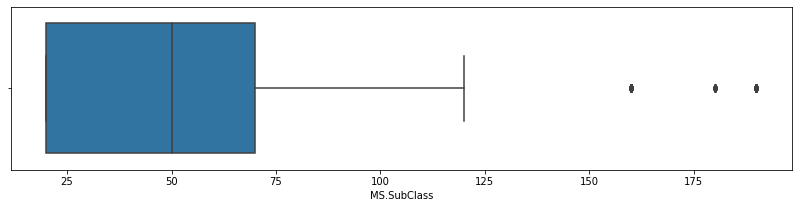

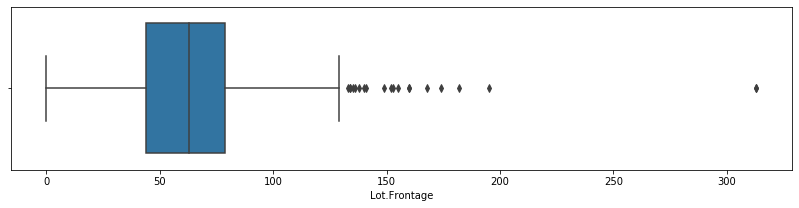

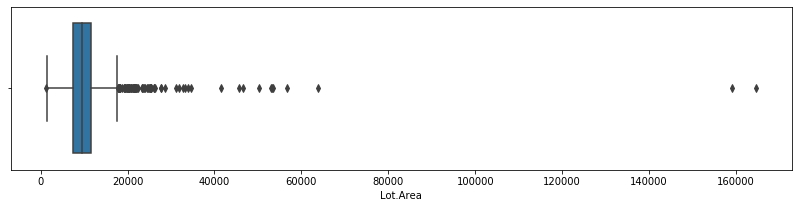

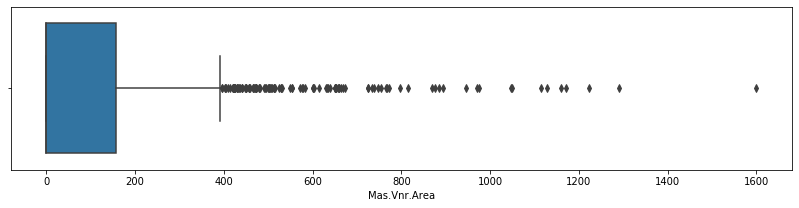

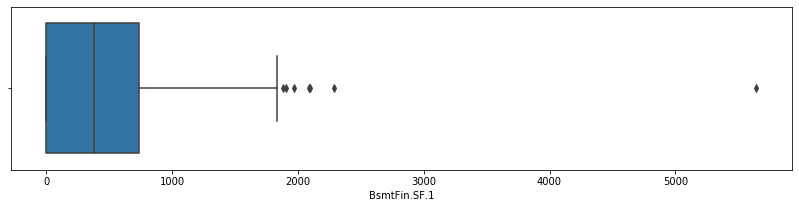

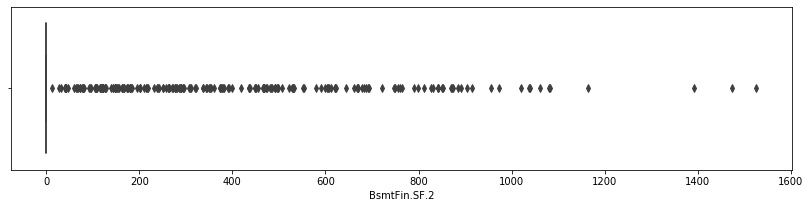

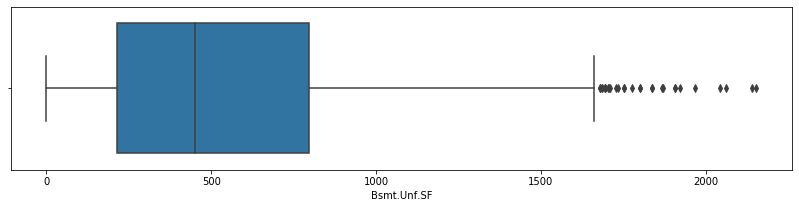

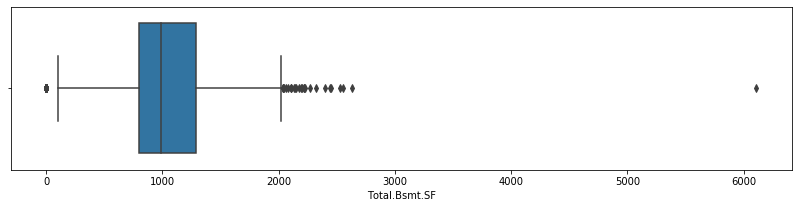

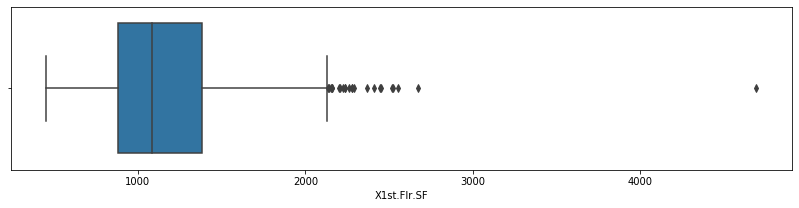

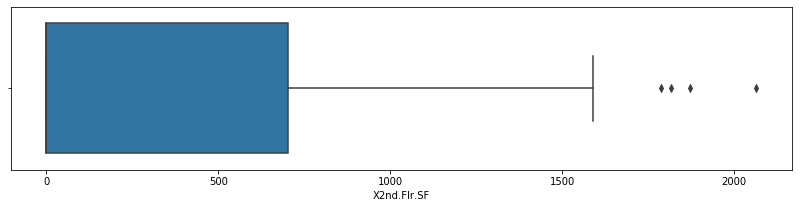

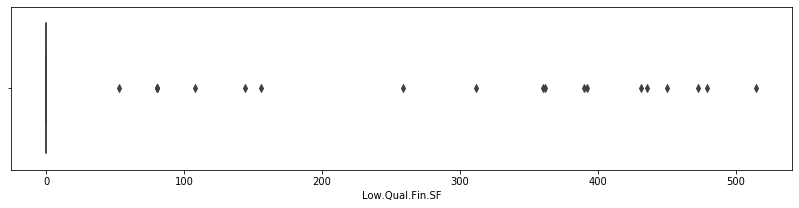

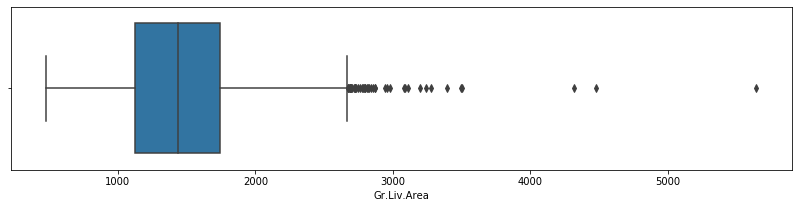

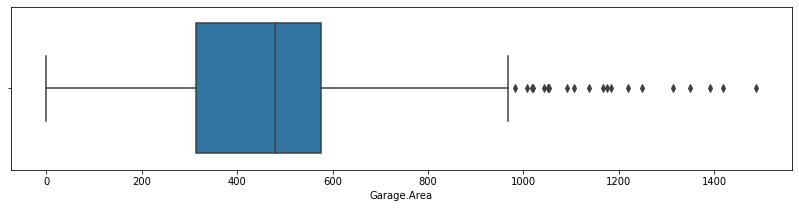

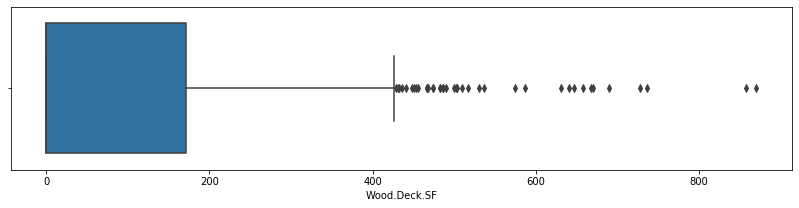

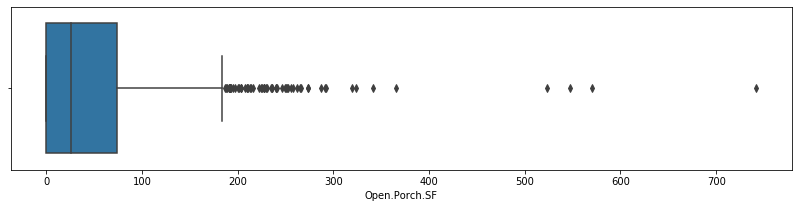

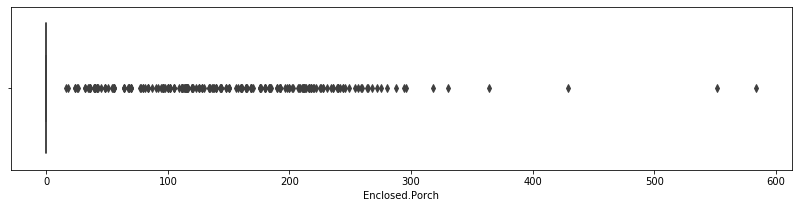

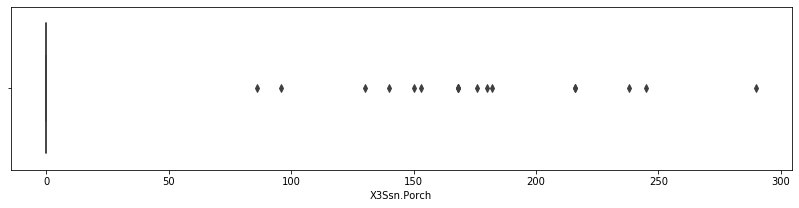

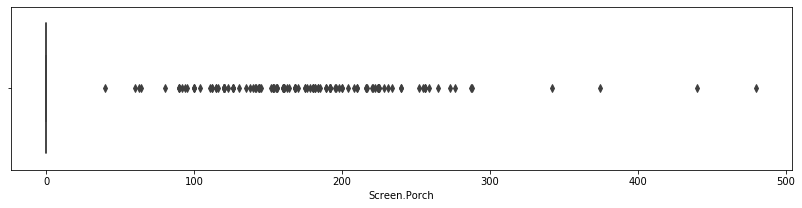

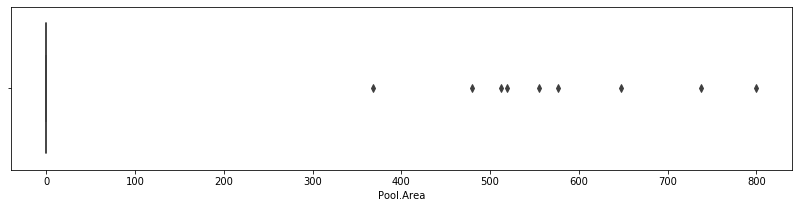

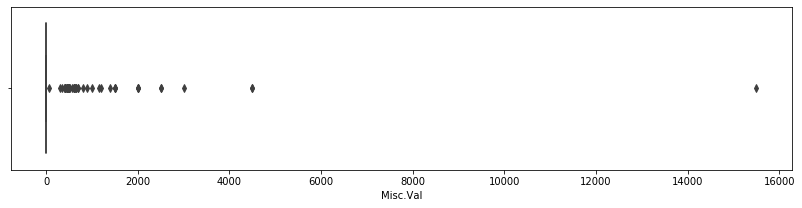

In [93]:
for column in outlier_columns:
    fig, ax = plt.subplots(figsize=(14,3))
    sns.boxplot(X_train[column])
    plt.show()

#### Wyodrębniam rozkłady ćwiartkowe i podstawowe statystyki w celu normalizacji

In [94]:
outliers = ['MS.SubClass', 'Lot.Frontage', 'Lot.Area', 'Mas.Vnr.Area', 'BsmtFin.SF.1', 'BsmtFin.SF.2', 'Bsmt.Unf.SF', 'Total.Bsmt.SF',
            'X1st.Flr.SF', 'X2nd.Flr.SF', 'Low.Qual.Fin.SF', 'Gr.Liv.Area', 'Garage.Area', 'Wood.Deck.SF',
           'Open.Porch.SF', 'Enclosed.Porch', 'X3Ssn.Porch', 'Screen.Porch', 'Pool.Area', 'Misc.Val']
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
IQR[outliers]

MS.SubClass         50.00
Lot.Frontage        35.00
Lot.Area          4063.25
Mas.Vnr.Area       157.25
BsmtFin.SF.1       734.50
BsmtFin.SF.2         0.00
Bsmt.Unf.SF        580.00
Total.Bsmt.SF      492.50
X1st.Flr.SF        501.25
X2nd.Flr.SF        704.00
Low.Qual.Fin.SF      0.00
Gr.Liv.Area        619.25
Garage.Area        261.50
Wood.Deck.SF       171.00
Open.Porch.SF       74.00
Enclosed.Porch       0.00
X3Ssn.Porch          0.00
Screen.Porch         0.00
Pool.Area            0.00
Misc.Val             0.00
dtype: float64

#### Obliczam kolejno:
<ul>

<li> minimalne wartości zmiennych
<li> maksymalne wartości zmiennych
<li> lewy brzeg zakresu, który należy uznać za normalny
<li> prawy brzeg zakresu, który należy uznać za normalny
<li> odchylenie standardowe

#### Prezentuję dane w tabeli w celu ułatwienia dalszej analizy

In [95]:
mins = np.min(X_train) 
maxs = np.max(X_train) 
left = Q1 - 1.5 * IQR 
right = Q3 + 1.5 * IQR 
std = np.std(X_train) 

In [96]:
pd.DataFrame({'Q1': Q1[outliers], 'Q3': Q3[outliers], 'IQR': IQR[outliers], 
              'min': mins[outliers], 'max': maxs[outliers], 'std': std[outliers], 
              'left (Q1 - 1.5x IQR)': left[outliers], 'right (Q3 + 1.5x IQR)': right[outliers]})

,Q1,Q3,IQR,min,max,std,left (Q1 - 1.5x IQR),right (Q3 + 1.5x IQR)
MS.SubClass,20.00,70.00,50.00,20.00,190.00,41.77,-55.00,145.00
Lot.Frontage,44.00,79.00,35.00,0.00,313.00,33.91,-8.50,131.50
Lot.Area,7559.50,11622.75,4063.25,1300.00,164660.00,7506.25,1464.62,17717.62
Mas.Vnr.Area,0.00,157.25,157.25,0.00,1600.00,182.50,-235.88,393.12
BsmtFin.SF.1,0.00,734.50,734.50,0.00,5644.00,454.39,-1101.75,1836.25
BsmtFin.SF.2,0.00,0.00,0.00,0.00,1526.00,175.72,0.00,0.00
Bsmt.Unf.SF,216.00,796.00,580.00,0.00,2153.00,437.29,-654.00,1666.00
Total.Bsmt.SF,796.00,1288.50,492.50,0.00,6110.00,432.36,57.25,2027.25
X1st.Flr.SF,882.00,1383.25,501.25,453.00,4692.00,377.89,130.12,2135.12
X2nd.Flr.SF,0.00,704.00,704.00,0.00,2065.00,430.25,-1056.00,1760.00


#### Bazując na powyższych obliczeniach wyznaczam granice normalności (pomijam granice zerowe), w przypadku wartości ujemnych nie uwzględniam ich w dalszych krokach - granicą będzie wartość '0'

In [97]:
right_MSSC = right['MS.SubClass']
right_LF = right['Lot.Frontage']
left_LA = left['Lot.Area']
right_LA = right['Lot.Area']
right_MVA = right['Mas.Vnr.Area']
right_BS1 = right['BsmtFin.SF.1']
right_BUSF = right['Bsmt.Unf.SF']
right_TBSF = right['Total.Bsmt.SF']
left_TBSF = left['Total.Bsmt.SF']
right_X1 = right['X1st.Flr.SF']
left_X1 = left['X1st.Flr.SF']
right_X2 = right['X2nd.Flr.SF']
right_GLA = right['Gr.Liv.Area']
left_GLA = left['Gr.Liv.Area']
right_GA = right['Garage.Area']
right_WDSF = right['Wood.Deck.SF']
right_OPSF = right['Open.Porch.SF']

In [98]:
X_train['MS.SubClass'] = X_train['MS.SubClass'].apply(
        lambda x: 0 if x == np.nan else x if x < right_MSSC else right_MSSC)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
X_train['Lot.Frontage'] = X_train['Lot.Frontage'].apply(
        lambda x: 0 if x == np.nan else x if x < right_LF else right_LF)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [100]:
X_train['Lot.Area'] = X_train['Lot.Area'].apply(
        lambda x: right_LA if x > right_LA else left_LA if x < left_LA else x)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [101]:
X_train['Mas.Vnr.Area'] = X_train['Mas.Vnr.Area'].apply(
        lambda x: 0 if x == np.nan else x if x < right_MVA else right_MVA)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
X_train['BsmtFin.SF.1'] = X_train['BsmtFin.SF.1'].apply(
        lambda x: 0 if x == np.nan else x if x < right_BS1 else right_BS1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
X_train['Bsmt.Unf.SF'] = X_train['Bsmt.Unf.SF'].apply(
        lambda x: 0 if x == np.nan else x if x < right_BUSF else right_BUSF)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [104]:
X_train['Total.Bsmt.SF'] = X_train['Total.Bsmt.SF'].apply(
        lambda x: right_TBSF if x > right_TBSF else left_TBSF if x < left_TBSF else x)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [105]:
X_train['X1st.Flr.SF'] = X_train['X1st.Flr.SF'].apply(
        lambda x: right_X1 if x > right_X1 else left_X1 if x < left_X1 else x)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [106]:
X_train['Gr.Liv.Area'] = X_train['Gr.Liv.Area'].apply(
        lambda x: right_GLA if x > right_GLA else left_GLA if x < left_GLA else x)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
X_train['X2nd.Flr.SF'] = X_train['X2nd.Flr.SF'].apply(
        lambda x: 0 if x == np.nan else x if x < right_X2 else right_X2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [108]:
X_train['Garage.Area'] = X_train['Garage.Area'].apply(
        lambda x: 0 if x == np.nan else x if x < right_GA else right_GA)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [109]:
X_train['Wood.Deck.SF'] = X_train['Wood.Deck.SF'].apply(
        lambda x: 0 if x == np.nan else x if x < right_WDSF else right_WDSF)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
X_train['Open.Porch.SF'] = X_train['Open.Porch.SF'].apply(
        lambda x: 0 if x == np.nan else x if x < right_OPSF else right_OPSF)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [111]:
X_train

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition
984,80.00,2,0.00,10448.00,1,0,3,4,1,3,3,7,7,5,5,1,6,6,1972,1972,5,6,1,4,3,333.00,2,2,5,3,3,1,1,0.00,1,0,689.00,689.00,5,3,1,4,1378.00,741.00,0,2119.00,0,0,2,1,3,1,2,7,8,1,3,5,1972,2,2,583.00,3,3,3,0.00,104.00,0,0,0,0,0,4,0,0,8,2009,6.00,5
1922,20.00,2,0.00,12285.00,1,0,3,4,1,4,3,15,7,5,5,8,7,6,1960,1960,5,6,1,2,3,128.00,2,2,5,3,3,1,4,544.00,1,0,785.00,1329.00,5,4,1,4,1329.00,0.00,0,1329.00,0,0,1,1,3,1,2,5,8,2,4,5,1960,1,2,441.00,3,3,3,0.00,0.00,203,0,0,0,0,0,0,0,8,2009,10.00,6
1752,70.00,2,60.00,9550.00,1,0,3,4,1,3,3,3,7,5,5,5,7,5,1915,1970,5,6,1,1,0,0.00,2,2,6,3,4,1,5,216.00,1,0,540.00,756.00,5,4,1,4,961.00,756.00,0,1717.00,1,0,1,0,3,1,3,7,8,1,4,1,1998,1,3,642.00,3,3,3,0.00,35.00,272,0,0,0,0,0,0,0,2,2006,10.00,5
1798,20.00,2,0.00,17600.00,1,0,3,4,1,4,3,15,7,5,5,8,6,5,1960,1960,5,6,1,3,3,30.00,2,2,5,3,3,1,4,1270.00,1,0,208.00,1478.00,5,5,1,3,1478.00,0.00,0,1478.00,1,0,2,0,3,1,2,6,8,2,4,5,1960,1,2,498.00,3,3,3,0.00,40.00,0,0,0,0,0,0,0,0,12,2009,10.00,6
1862,20.00,2,75.00,7500.00,1,0,4,4,1,3,3,8,8,5,5,8,5,5,1963,1963,5,6,1,4,0,0.00,2,2,5,3,3,1,5,824.00,1,0,216.00,1040.00,5,2,1,4,1040.00,0.00,0,1040.00,1,0,1,1,3,1,2,5,8,0,0,5,1963,3,1,308.00,3,3,3,0.00,0.00,220,0,0,0,0,3,0,0,6,2010,10.00,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,20.00,5,85.00,10625.00,1,0,4,4,1,4,3,11,7,5,5,8,7,5,2006,2007,5,6,5,6,0,0.00,3,2,4,4,3,1,6,1430.00,1,0,222.00,1652.00,5,5,1,4,1662.00,0.00,0,1662.00,1,0,2,0,3,1,4,8,8,1,4,5,2006,2,3,711.00,3,3,3,168.00,120.00,0,0,0,0,0,0,0,0,3,2009,10.00,6
1249,20.00,2,65.00,8775.00,1,0,4,4,1,4,3,14,7,5,5,8,5,5,1994,1994,5,6,5,6,0,0.00,2,2,4,4,3,1,6,495.00,1,0,495.00,990.00,5,4,1,4,990.00,0.00,0,990.00,0,0,1,0,3,1,2,5,8,0,0,5,1996,1,1,299.00,3,3,3,0.00,64.00,0,0,0,0,0,0,0,0,4,2007,10.00,6
782,145.00,1,60.00,10800.00,1,2,4,4,1,4,3,13,7,5,4,7,6,6,1940,1950,5,6,1,3,0,0.00,2,2,5,3,3,1,4,590.00,1,0,294.00,884.00,5,3,1,4,884.00,552.00,0,1436.00,0,0,2,0,3,2,2,8,8,2,4,1,1940,1,2,828.00,3,3,3,0.00,0.00,126,0,0,0,0,0,0,0,5,2008,5.00,6
443,50.00,2,59.00,16466.00,1,0,3,4,1,4,3,12,7,5,5,7,5,7,1955,1955,5,6,1,5,0,0.00,2,3,4,3,3,1,1,0.00,1,0,816.00,816.00,5,3,1,4,872.00,521.00,0,1393.00,0,0,1,1,3,1,2,8,8,0,0,5,1955,1,1,300.00,3,3,3,121.00,0.00,0,0,265,0,0,0,0,0,4,2008,10.00,6


### Powyższy proces "czyszczenia" danych powtarzam na zbiorze danych testowych

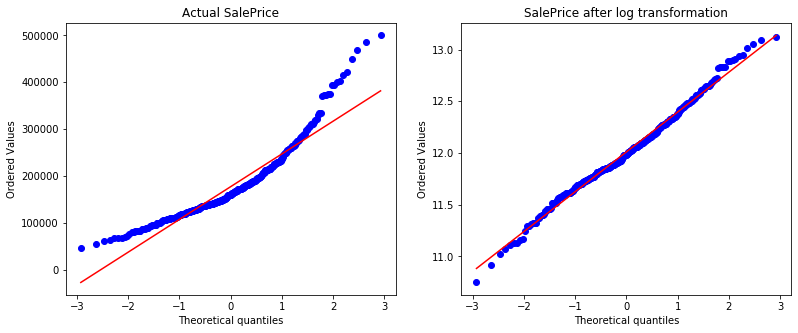

<Figure size 432x288 with 0 Axes>

In [112]:
figure = plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
stats.probplot(y_test, plot = plt)
plt.title('Actual SalePrice')
plt.subplot(1,2,2)

y_test = np.log(y_test)
stats.probplot(y_test, plot = plt)
plt.title('SalePrice after log transformation')
plt.show()
plt.savefig('SalePrice.jpg')

In [113]:
X_test["Mas.Vnr.Type"].fillna('None', inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [114]:
X_test['Lot.Frontage'].fillna(0, inplace=True)

In [115]:
X_test["Garage.Cond"].fillna('None', inplace=True)
X_test['Garage.Finish'].fillna('None', inplace=True)
X_test['Garage.Qual'].fillna('None', inplace=True)
X_test['Mas.Vnr.Type'].fillna('None', inplace=True)
X_test['BsmtFin.Type.2'].fillna('None', inplace=True)
X_test['BsmtFin.Type.1'].fillna('None', inplace=True)
X_test['Bsmt.Exposure'].fillna('None', inplace=True)
X_test['Bsmt.Cond'].fillna('None', inplace=True)
X_test['Bsmt.Qual'].fillna('None', inplace=True)

In [116]:
X_test['Electrical'].fillna(X_test['Electrical'].mode()[0], inplace=True)

In [117]:
X_test['Utilities'] = X_test['Utilities'].apply(lambda x: x if 'AllPub' else 'Other')
X_test['Utilities'] = X_test['Utilities'].map({"Other":0, 
                                               "AllPub":1})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
mp = {'N': 0, 'Y':1}
for feat in ['Central.Air']:
 X_test[feat] = X_test[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [119]:
mp = {'Grvl':2, 'Pave':1}
for feat in ['Street']:
 X_test[feat] = X_test[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [120]:
mp = {'None': 0, 'Grvl':2, 'Pave':1}
for feat in ['Alley']:
 X_test[feat] = X_test[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [121]:
mp = {'Gtl': 3, 'Mod':2, 'Sev':1}
for feat in ['Land.Slope']:
 X_test[feat] = X_test[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
mp = {'Y': 3, 'P':2, 'N':1}
for feat in ['Paved.Drive']:
 X_test[feat] = X_test[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [123]:
mp = {'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1}
for feat in ['Exter.Qual', 'Exter.Cond', 'Kitchen.Qual']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [124]:
mp = {'Reg': 4, 'IR1':3, 'IR2':2, 'IR3':1}
for feat in ['Lot.Shape']:
 X_test[feat] = X_test[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [125]:
mp = {'Lvl': 4, 'Bnk':3, 'HLS':2, 'Low':1}
for feat in ['Land.Contour']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [126]:
mp = {'SBrkr': 4, 'FuseA':3, 'FuseF':2, 'FuseP':1}
for feat in ['Electrical']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [127]:
mp = {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
for feat in ['Heating.QC']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [128]:
mp = {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0}
for feat in ['Bsmt.Qual', 'Bsmt.Cond', 'Garage.Qual', 'Garage.Cond', 'Fireplace.Qu']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [129]:
mp = {'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'None':0}
for feat in ['Pool.QC']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [130]:
mp = {'BrkCmn': 4, 'BrkFace':3, 'CBlock':2, 'Stone':1, 'None':0}
for feat in ['Mas.Vnr.Type']:
 X_test[feat] = X_test[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:
df["Mas.Vnr.Type"] = df["Mas.Vnr.Type"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [132]:
mp = {'1Fam': 5, '2fmCon':4, 'Duplex':3, 'Twnhs':2, 'TwnhsE':1}
for feat in ['Bldg.Type']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [133]:
mp = {'Fin': 3, 'RFn':2, 'Unf':1, 'None':0}
for feat in ['Garage.Finish']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [134]:
mp = {'Inside': 4, 'Corner':3, 'CulDSac':2, 'FR2':1, 'FR3':0}
for feat in ['Lot.Config']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [135]:
mp = {'GdPrv': 4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'None':0}
for feat in ['Fence']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [136]:
mp = {'Gar2': 4, 'Othr':3, 'Shed':2, 'TenC':1, 'None':0}
for feat in ['Misc.Feature']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [137]:
mp = {'Floor': 6, 'GasA':5, 'GasW':4, 'Grav':3, 'OthW':2, 'Wall':1}
for feat in ['Heating']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [138]:
mp = {'Gd': 4, 'Av':3, 'Mn':2, 'No':1, 'None':0}
for feat in ['Bsmt.Exposure']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
mp = {'Normal': 6, 'Abnorml':5, 'AdjLand':4, 'Alloca':3, 'Family':2, 'Partial':1}
for feat in ['Sale.Condition']:
 X_test[feat] = X_test[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [140]:
mp = {'A (agr)': 7, 'C (all)':6, 'FV':5, 'I (all)':4, 'RH':3, 'RL':2, 'RM':1}
for feat in ['MS.Zoning']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [141]:
mp = {'Artery': 7, 'Feedr':6, 'Norm':5, 'PosA':4, 'PosN':3, 'RRNn':2, 'RRAn':1}
for feat in ['Condition.2']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [142]:
mp = {'Artery': 9, 'Feedr':8, 'Norm':7, 'RRNn':6, 'RRAn':5, 'PosN':4, 'PosA':3, 'RRNe':2, 'RRAe':1}
for feat in ['Condition.1']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [143]:
mp = {'BrkTil': 6, 'CBlock':5, 'PConc':4, 'Slab':3, 'Stone':2, 'Wood':1}
for feat in ['Foundation']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [144]:
mp = {'Flat': 6, 'Gable':5, 'Gambrel':4, 'Hip':3, 'Mansard':2, 'Shed':1}
for feat in ['Roof.Style']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [145]:
mp = {'ClyTile': 7, 'CompShg':6, 'Membran':5, 'Metal':4, 'Tar&Grv':3, 'WdShake':2, 'WdShngl':1}
for feat in ['Roof.Matl']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [146]:
mp = {'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1}
for feat in ['Functional']:
 X_test[feat] = X_test[feat].map(mp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [147]:
mp = {'GLQ': 6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'None':0}
for feat in ['BsmtFin.Type.1', 'BsmtFin.Type.2']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [148]:
mp = {'1Story': 8, '1.5Fin':7, '1.5Unf':6, '2Story':5, '2.5Fin':4, '2.5Unf':3, 'SFoyer':2, 'SLvl':1}
for feat in ['House.Style']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [149]:
mp = {'2Types': 6, 'Attchd':5, 'Basment':4, 'BuiltIn':3, 'CarPort':2, 'Detchd':1, 'None':0}
for feat in ['Garage.Type']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [150]:
mp = {'WD':10, 'CWD':9, 'VWD':8, 'New':7, 'COD':6, 'Con':5, 'ConLw':4, 'ConLI':3, 'ConLD':2, 'Oth':1}
for feat in ['Sale.Type']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [151]:
X_test['Sale.Type'].fillna(10, inplace = True)

In [152]:
mp = {'None': 0, '1':1, '2':2, '3':3, "0":0}
for feat in ['Bsmt.Full.Bath']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
mp = {'None': 0, '1':1, '2':2, '0':0}
for feat in ['Bsmt.Half.Bath']:
 X_test[feat] = X_test[feat].map(mp) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [154]:
df_exterior = pd.DataFrame(X_test['Exterior.1st'].value_counts())
exterior_list = (df_exterior[(df_exterior['Exterior.1st'] > 250)].index)

In [155]:
X_test['Exterior.1st'] = X_test['Exterior.1st'].apply(lambda x: x if x in exterior_list else 'Other')
X_test['Exterior.1st'] = X_test['Exterior.1st'].map({"Other":1, 
                                                       "Wd Sdng":2,
                                                       'HdBoard':3, 
                                                       'MetalSd':4, 
                                                       'VinylSd':5})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [156]:
df_exterior2 = pd.DataFrame(X_test['Exterior.2nd'].value_counts())
exterior2_list = (df_exterior2[(df_exterior2['Exterior.2nd'] > 100)].index)

In [157]:
X_test['Exterior.2nd'] = X_test['Exterior.2nd'].apply(lambda x: x if x in exterior2_list else 'Other')
X_test['Exterior.2nd'] = X_test['Exterior.2nd'].map({"Other":1, 
                                                       'Plywood':2,
                                                       "Wd Sdng":3,
                                                       'HdBoard':4, 
                                                       'MetalSd':5, 
                                                       'VinylSd':6})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [158]:
df_neighborhood = pd.DataFrame(X_test['Neighborhood'].value_counts())
neighborhood_list = (df_neighborhood[(df_neighborhood['Neighborhood'] > 50)].index)

In [159]:
X_test['Neighborhood'] = X_test['Neighborhood'].apply(lambda x: x if x in neighborhood_list else 'Other')
X_test['Neighborhood'] = X_test['Neighborhood'].map({"Other":1, 
                                                       'IDOTRR':2,
                                                       'Crawfor':3,
                                                       'Mitchel':4,
                                                       'BrkSide':5, 
                                                       'SawyerW':6, 
                                                       'NWAmes':7,
                                                       'Sawyer':8,
                                                       'NridgHt':9,
                                                       'Gilbert':10,
                                                       'Somerst':11,
                                                       'Edwards':12,
                                                       'OldTown':13,
                                                       'CollgCr':14,
                                                       'Nonemes':15})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [160]:
filter = X_test['Garage.Yr.Blt']=='None'
X_test['Garage.Yr.Blt'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [161]:
X_test["Garage.Yr.Blt"] = X_test["Garage.Yr.Blt"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [162]:
filter = X_test['Lot.Frontage']=='None'
X_test['Lot.Frontage'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [163]:
X_test["Lot.Frontage"] = X_test["Lot.Frontage"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [164]:
filter = X_test['BsmtFin.SF.2']=='None'
X_test['BsmtFin.SF.2'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [165]:
X_test["BsmtFin.SF.2"] = X_test["BsmtFin.SF.2"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [166]:
filter = X_test['Garage.Area']=='None'
X_test['Garage.Area'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [167]:
X_test["Garage.Area"] = X_test["Garage.Area"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [168]:
filter = X_test['BsmtFin.SF.1']=='None'
X_test['BsmtFin.SF.1'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [169]:
X_test["BsmtFin.SF.1"] = X_test["BsmtFin.SF.1"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [170]:
filter = X_test['Total.Bsmt.SF']=='None'
X_test['Total.Bsmt.SF'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [171]:
X_test["Total.Bsmt.SF"] = X_test["Total.Bsmt.SF"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [172]:
filter = X_test['Bsmt.Unf.SF']=='None'
X_test['Bsmt.Unf.SF'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [173]:
X_test["Bsmt.Unf.SF"] = X_test["Bsmt.Unf.SF"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [174]:
filter = X_test['Garage.Cars']=='None'
X_test['Garage.Cars'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [175]:
X_test["Garage.Cars"] = X_test["Garage.Cars"].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [176]:
filter = X_test['Mas.Vnr.Area']=='None'
X_test['Mas.Vnr.Area'][filter] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [177]:
X_test['Mas.Vnr.Area'] = X_test['Mas.Vnr.Area'].astype(str).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [178]:
Q1 = X_test.quantile(0.25)
Q3 = X_test.quantile(0.75)
IQR = Q3 - Q1
IQR[outliers]

MS.SubClass         60.00
Lot.Frontage        38.00
Lot.Area          3942.25
Mas.Vnr.Area       143.00
BsmtFin.SF.1       738.75
BsmtFin.SF.2         0.00
Bsmt.Unf.SF        585.25
Total.Bsmt.SF      520.00
X1st.Flr.SF        548.50
X2nd.Flr.SF        681.25
Low.Qual.Fin.SF      0.00
Gr.Liv.Area        558.50
Garage.Area        238.00
Wood.Deck.SF       154.50
Open.Porch.SF       62.25
Enclosed.Porch       0.00
X3Ssn.Porch          0.00
Screen.Porch         0.00
Pool.Area            0.00
Misc.Val             0.00
dtype: float64

In [179]:
mins = np.min(X_test) 
maxs = np.max(X_test) 
left = Q1 - 1.5 * IQR 
right = Q3 + 1.5 * IQR 
std = np.std(X_test) 

In [180]:
X_test['MS.SubClass'] = X_test['MS.SubClass'].apply(
        lambda x: 0 if x == np.nan else x if x < right_MSSC else right_MSSC)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [181]:
X_test['Lot.Frontage'] = X_test['Lot.Frontage'].apply(
        lambda x: 0 if x == np.nan else x if x < right_LF else right_LF)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [182]:
X_test['Lot.Area'] = X_test['Lot.Area'].apply(
        lambda x: right_LA if x > right_LA else left_LA if x < left_LA else x)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [183]:
X_test['Mas.Vnr.Area'] = X_test['Mas.Vnr.Area'].apply(
        lambda x: 0 if x == np.nan else x if x < right_MVA else right_MVA)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [184]:
X_test['BsmtFin.SF.1'] = X_test['BsmtFin.SF.1'].apply(
        lambda x: 0 if x == np.nan else x if x < right_BS1 else right_BS1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [185]:
X_test['Bsmt.Unf.SF'] = X_test['Bsmt.Unf.SF'].apply(
        lambda x: 0 if x == np.nan else x if x < right_BUSF else right_BUSF)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [186]:
X_test['Total.Bsmt.SF'] = X_test['Total.Bsmt.SF'].apply(
        lambda x: right_TBSF if x > right_TBSF else left_TBSF if x < left_TBSF else x)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [187]:
X_test['X1st.Flr.SF'] = X_test['X1st.Flr.SF'].apply(
        lambda x: right_X1 if x > right_X1 else left_X1 if x < left_X1 else x)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [188]:
X_test['Gr.Liv.Area'] = X_test['Gr.Liv.Area'].apply(
        lambda x: right_GLA if x > right_GLA else left_GLA if x < left_GLA else x)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [189]:
X_test['X2nd.Flr.SF'] = X_test['X2nd.Flr.SF'].apply(
        lambda x: 0 if x == np.nan else x if x < right_X2 else right_X2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [190]:
X_test['Garage.Area'] = X_test['Garage.Area'].apply(
        lambda x: 0 if x == np.nan else x if x < right_GA else right_GA)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [191]:
X_test['Wood.Deck.SF'] = X_test['Wood.Deck.SF'].apply(
        lambda x: 0 if x == np.nan else x if x < right_WDSF else right_WDSF)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [192]:
X_test['Open.Porch.SF'] = X_test['Open.Porch.SF'].apply(
        lambda x: 0 if x == np.nan else x if x < right_OPSF else right_OPSF)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [193]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 757 to 1930
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS.SubClass      400 non-null    float64
 1   MS.Zoning        400 non-null    int64  
 2   Lot.Frontage     400 non-null    float64
 3   Lot.Area         400 non-null    float64
 4   Street           400 non-null    int64  
 5   Alley            400 non-null    int64  
 6   Lot.Shape        400 non-null    int64  
 7   Land.Contour     400 non-null    int64  
 8   Utilities        400 non-null    int64  
 9   Lot.Config       400 non-null    int64  
 10  Land.Slope       400 non-null    int64  
 11  Neighborhood     400 non-null    int64  
 12  Condition.1      400 non-null    int64  
 13  Condition.2      400 non-null    int64  
 14  Bldg.Type        400 non-null    int64  
 15  House.Style      400 non-null    int64  
 16  Overall.Qual     400 non-null    int64  
 17  Overall.Cond 

# Część II - Modelowanie

### Model 1 - Linear Regression

In [194]:
linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
np.unique(y_pred)

array([10.94227382, 11.04113512, 11.05102285, 11.06098292, 11.09332085,
       11.13539908, 11.15702276, 11.1684166 , 11.23835991, 11.28193884,
       11.30834867, 11.31084243, 11.31199411, 11.31728221, 11.36438654,
       11.37483556, 11.39494257, 11.39987081, 11.40569419, 11.41290671,
       11.42060648, 11.42899081, 11.43341271, 11.45350007, 11.46024701,
       11.48713505, 11.49144693, 11.51065794, 11.51082042, 11.51357036,
       11.51647635, 11.52161357, 11.52575772, 11.53636299, 11.54418688,
       11.54447514, 11.56553942, 11.56572215, 11.56642548, 11.56762657,
       11.56835767, 11.56874136, 11.57236743, 11.57385535, 11.57724217,
       11.58228151, 11.58307599, 11.59177769, 11.59484795, 11.60793577,
       11.61357807, 11.61623055, 11.61851232, 11.61854344, 11.62255023,
       11.63254275, 11.63328627, 11.63352091, 11.63684038, 11.63908708,
       11.64616641, 11.6492634 , 11.65608691, 11.66940776, 11.67231649,
       11.67344746, 11.67512017, 11.67935585, 11.68355222, 11.68

In [195]:
from sklearn.metrics import r2_score

r2_linear = r2_score(y_test,linear.predict(X_test))
r2_linear

0.9011157368973842

### Model 2 - Ridge

In [196]:
ridge = Ridge(alpha=1).fit(X_train, y_train)

In [197]:
r2_ridge = r2_score(y_test,ridge.predict(X_test))
r2_ridge

0.901890897577224

#### Optymalizacja

In [198]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.8973698684755691
Best Params:  {'alpha': 100}


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.7s finished


In [199]:
ridge_opt = Ridge(alpha=100).fit(X_train, y_train)

In [200]:
r2_ridge_opt = r2_score(y_test,ridge_opt.predict(X_test))
r2_ridge_opt

0.9065137196137614

### Model 3 - Lasso

In [201]:
lasso = Lasso(alpha=1).fit(X_train, y_train)

In [202]:
r2_lasso = r2_score(y_test,lasso.predict(X_test))
r2_lasso

0.8116730105605569

#### Optimalizcja

In [203]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best Score:  0.8969601017306199
Best Params:  {'alpha': 0.001}


[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.4s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.409066764077238, tolerance: 0.026161888527128144
  positive)


In [204]:
lasso_opt = Lasso(alpha=0.001).fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.409066764077238, tolerance: 0.026161888527128144
  positive)


In [205]:
r2_lasso_opt = r2_score(y_test,lasso_opt.predict(X_test))
r2_lasso_opt

0.9068445826924827

### Model 4 - Elastic Net

In [206]:
elasticnet = ElasticNet()
elasticnet.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [207]:
r2_elasticnet = r2_score(y_test,elasticnet.predict(X_test))
r2_elasticnet

0.8318402365445188

#### Optymalizacja

In [208]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=elasticnet, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.8970824069213357
Best Params:  {'alpha': 0.001}


[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.4s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3250675672213266, tolerance: 0.026161888527128144
  positive)


In [209]:
elasticnet_opt = ElasticNet(alpha=0.01).fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11454830001611072, tolerance: 0.026161888527128144
  positive)


In [210]:
r2_elsaticnet_opt = r2_score(y_test, elasticnet_opt.predict(X_test))
r2_elsaticnet_opt

0.9037810611264065

# Część 3 - prezentacja wyników i wnioski

In [211]:
names=[{'R2':'normal', 'Linear Regression':'0.8466740065794491', 'Ridge':'0.8476919317516166', 'Lasso':'0.740696498381515', 'Elastic Net':'0.7563044920977188'},
       {'R2': 'standarized', 'Linear Regression':'None', 'Ridge':'0.8480507711350997', 'Lasso':'0.8502140254722401', 'Elastic Net':'0.8444484176096035'}]
      
df3=pd.DataFrame(names)
df3

,R2,Linear Regression,Ridge,Lasso,Elastic Net
0,normal,0.8466740065794491,0.8476919317516166,0.740696498381515,0.7563044920977188
1,standarized,None,0.8480507711350997,0.8502140254722401,0.8444484176096035


In [212]:
data = [['Linear Regression', 'normal', '0.8466740065794491'],
        ['Ridge', 'normal', '0.8476919317516166'],
        ['Lasso', 'normal', '0.740696498381515'],
        ['Elastic Net', 'normal', '0.7563044920977188'],
        ['Linear Regression', 'standarized', 'None'],
        ['Ridge', 'standarized - Alpha = 100', '0.8480507711350997'],
        ['Lasso', 'standarized - Alpha = 0.001', '0.8502140254722401'],
        ['Elastic Net', 'standarized - Alpha = 0.01', '0.8444484176096035']]
wyniki = pd.DataFrame(data, columns = ['Model Name', 'Optimalization + Best parameter', 'R2 Result'])
wyniki

,Model Name,Optimalization + Best parameter,R2 Result
0,Linear Regression,normal,0.8466740065794491
1,Ridge,normal,0.8476919317516166
2,Lasso,normal,0.740696498381515
3,Elastic Net,normal,0.7563044920977188
4,Linear Regression,standarized,None
5,Ridge,standarized - Alpha = 100,0.8480507711350997
6,Lasso,standarized - Alpha = 0.001,0.8502140254722401
7,Elastic Net,standarized - Alpha = 0.01,0.8444484176096035


In [213]:
wyniki.sort_values(by = 'R2 Result', ascending = False)

,Model Name,Optimalization + Best parameter,R2 Result
4,Linear Regression,standarized,None
6,Lasso,standarized - Alpha = 0.001,0.8502140254722401
5,Ridge,standarized - Alpha = 100,0.8480507711350997
1,Ridge,normal,0.8476919317516166
0,Linear Regression,normal,0.8466740065794491
7,Elastic Net,standarized - Alpha = 0.01,0.8444484176096035
3,Elastic Net,normal,0.7563044920977188
2,Lasso,normal,0.740696498381515


#### Najlepszym wynikiem charakteryzuje się model Regresji Lasso z optymalizacją parametru alpha do wartości 0,001, jego r2 to 85% - dopasowanie jest bardzo wysokie. Jakość tego modelu jest zatem wysoce zadowalająca.